In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

pickle_file = 'results_and_resampled_data.pickle'

if not os.path.exists('plots'):
    os.makedirs('plots')

with open(pickle_file, 'rb') as f:
    data = pickle.load(f)

# Open data/participants.csv
participant_start = {}
with open('data/participants.csv', 'r') as f:
    plines = f.readlines()
assert plines[0].strip().replace(' ','') == 'Participant,Startedwith', 'First line of participants.csv must be "Participant,Start"'

for line in plines[1:]:
    participant, startedwith = line.strip().split(',')
    participant = participant.strip()
    assert participant in data.keys(), 'Participant {} not found in data'.format(participant)

    startedwith = startedwith.strip()
    assert startedwith in ['2D', '3D'], 'Startedwith must be either 2D or 3D'
    participant_start[participant] = startedwith

ALLTRACKS = ['Percussions (ID1)','Xylophone (ID3)', 'Texture (ID5)', 'Brass (ID7)', 'Voice (ID9)']



# Create barplot of MAE with a bar for each participant and for automation 0
bar_width = 0.35
part_spacing = 0.5
opacity = 0.8

maes_X = []
maes_X_startedwith2D = []
maes_X_startedwith3D = []
maes_Y = []
maes_Y_startedwith2D = []
maes_Y_startedwith3D = []
maes_Z = []
maes_Z_startedwith2D = []
maes_Z_startedwith3D = []

import pandas as pd
df_maes = pd.DataFrame(columns=['player', 'startedwith', 'track', 'mae-X', 'mae-Y', 'mae-Z'])

for participant in data:
    alltrack_maesX = []
    alltrack_maesY = []
    alltrack_maesZ = []

    assert all([track in data[participant].keys() for track in ALLTRACKS]), 'Participant {} does not have data for all tracks'.format(participant)


    for track in ALLTRACKS:
        automationX = 'Recording Trajectory X / ControlGris'
        automationY = 'Recording Trajectory Y / ControlGris'
        automationZ = 'Recording Trajectory Z / ControlGris'

        # print('data[%s][%s].keys():'%(participant,track), data[participant][track].keys())

        assert automationX in data[participant][track], 'Participant {} does not have data for automation {}'.format(participant, automationX)
        assert automationY in data[participant][track], 'Participant {} does not have data for automation {}'.format(participant, automationY)
        assert automationZ in data[participant][track], 'Participant {} does not have data for automation {}'.format(participant, automationZ)

        alltrack_maesX.append(data[participant][track][automationX]['metrics']['mae'])
        alltrack_maesY.append(data[participant][track][automationY]['metrics']['mae'])
        alltrack_maesZ.append(data[participant][track][automationZ]['metrics']['mae'])

        newrow = {'player': participant,
                  'startedwith': participant_start[participant],
                  'track': track,
                  'mae-X': data[participant][track][automationX]['metrics']['mae'],
                  'mae-Y': data[participant][track][automationY]['metrics']['mae'],
                  'mae-Z': data[participant][track][automationZ]['metrics']['mae']}

        df_maes = pd.concat([df_maes, pd.DataFrame([newrow])], ignore_index=True)
    
    maes_X_towrite = np.mean(alltrack_maesX) if len(alltrack_maesX) > 0 else 1.0
    maes_X.append(maes_X_towrite)

    maes_Y_towrite = np.mean(alltrack_maesY) if len(alltrack_maesY) > 0 else 1.0
    maes_Y.append(maes_Y_towrite)

    maes_Z_towrite = np.mean(alltrack_maesZ) if len(alltrack_maesZ) > 0 else 1.0
    maes_Z.append(maes_Z_towrite)

    if participant_start[participant] == '2D':
        maes_X_startedwith2D.append(maes_X_towrite)
        maes_Y_startedwith2D.append(maes_Y_towrite)
        maes_Z_startedwith2D.append(maes_Z_towrite)
    elif participant_start[participant] == '3D':
        maes_X_startedwith3D.append(maes_X_towrite)
        maes_Y_startedwith3D.append(maes_Y_towrite)
        maes_Z_startedwith3D.append(maes_Z_towrite)
    else:
        raise ValueError('Participant {} has an invalid startedwith value'.format(participant))
    
maes_startedwith2D = (maes_X_startedwith2D, maes_Y_startedwith2D, maes_Z_startedwith2D)
maes_startedwith3D = (maes_X_startedwith3D, maes_Y_startedwith3D, maes_Z_startedwith3D)

assert len(maes_X) == len(maes_Y) == len(maes_Z), 'X, Y, and Z must have the same length'
assert len(maes_X) == len(list(data.keys())), 'X, Y, Z, and data must have the same length'
            
        # maes.append(np.mean(alltrack_maes))

df_maes

C:\Users\cimil\AppData\Local\Temp\ipykernel_21904\412120420.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_maes = pd.concat([df_maes, pd.DataFrame([newrow])], ignore_index=True)


,player,startedwith,track,mae-X,mae-Y,mae-Z
0,ID1,3D,Percussions (ID1),0.153319,0.157309,0.087452
1,ID1,3D,Xylophone (ID3),0.122137,0.074206,0.192513
2,ID1,3D,Texture (ID5),0.247730,0.276738,0.153294
3,ID1,3D,Brass (ID7),0.161690,0.190330,0.073078
4,ID1,3D,Voice (ID9),0.003554,0.011947,0.143097
5,ID2,2D,Percussions (ID1),0.192246,0.525665,0.037426
6,ID2,2D,Xylophone (ID3),0.250993,0.307958,0.088553
7,ID2,2D,Texture (ID5),0.244168,0.143857,0.034736
8,ID2,2D,Brass (ID7),0.257505,0.261928,0.071294
9,ID2,2D,Voice (ID9),0.009979,0.119786,0.046576


In [2]:
if not os.path.exists('res'):
    os.makedirs('res')
df_maes.to_csv('res/maes_TUTTE(tracce_e_dimensioni).csv', index=False)


# df_maes.groupby(['player','startedwith'])


# Group by player and startedwith, drop track and mean of X,Y,Z
df_maes_grouped = df_maes.copy()
df_maes_grouped = df_maes_grouped.drop(columns=['track'])
df_maes_grouped = df_maes_grouped.groupby(['player','startedwith']).mean().reset_index()
df_maes_grouped

,player,startedwith,mae-X,mae-Y,mae-Z
0,ID1,3D,0.137686,0.142106,0.129887
1,ID10,2D,0.122595,0.097466,0.083925
2,ID11,3D,0.223642,0.283259,0.209468
3,ID12,2D,0.144290,0.263823,0.184179
4,ID2,2D,0.190978,0.271839,0.055717
5,ID3,3D,0.183060,0.127863,0.140576
6,ID4,2D,0.083167,0.065357,0.302716
7,ID5,3D,0.184902,0.121640,0.134710
8,ID6,2D,0.269439,0.193277,0.278788
9,ID7,3D,0.222075,0.236385,0.161077


In [38]:

# matplotlib default colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


DO_PLOT_PER_PARTICIPANT = False

if DO_PLOT_PER_PARTICIPANT:
    fig, ax = plt.subplots()

    # print(maes)
    enlargeX = 1.2
    x_points = np.arange(len(maes_X)) * enlargeX
    for i,posx in enumerate(x_points):
        ax.bar(posx,               maes_X[i], bar_width, alpha=opacity, color = colors[0], label='X' if i == 0 else '', edgecolor='k')
        ax.bar(posx + bar_width,   maes_Y[i], bar_width, alpha=opacity, color = colors[1], label='Y' if i == 0 else '', edgecolor='k')
        ax.bar(posx + 2*bar_width, maes_Z[i], bar_width, alpha=opacity, color = colors[2], label='Z' if i == 0 else '', edgecolor='k')


    plt.xlabel('Participant')
    plt.ylabel('Mean Absolute Error')
    plt.title('Mean Absolute Error of tracjectories for each participant')
    plt.xticks(x_points+ bar_width, np.arange(1, len(maes_X)+1))
    plt.legend()

    plt.savefig('plots/ALLmae.png', dpi=300, bbox_inches='tight')
    plt.savefig('plots/ALLmae.pdf', dpi=300, bbox_inches='tight')
    plt.show()


In [4]:

## Now barplot collapsing all dimensions into one bar per participant
allmaes = []
stderror = []
for i in range(len(maes_X)):
    allmaes.append((maes_X[i]+maes_Y[i]+maes_Z[i])/3.0)
    stderror.append(np.std([maes_X[i],maes_Y[i],maes_Z[i]])/np.sqrt(3.0))


DO_PLOT_PER_PARTICIPANT2 = False

if DO_PLOT_PER_PARTICIPANT2:
    fig, ax = plt.subplots()
    enlargeX = 1.2
    x_points = np.arange(len(allmaes)) * enlargeX
    for i,posx in enumerate(x_points):
        ax.bar(posx, allmaes[i], alpha=opacity, color = colors[0], yerr=stderror[i], capsize=5, edgecolor='k')

    plt.xlabel('Participant')
    plt.ylabel('Mean Absolute Error')
    plt.title('Mean Absolute Error between 2D and 3D')
    plt.xticks(x_points, np.arange(1, len(allmaes)+1))


    plt.savefig('plots/mae_per_participant.png', dpi=300, bbox_inches='tight')
    plt.savefig('plots/mae_per_participant.pdf', dpi=300, bbox_inches='tight')
    plt.show()

SyntaxError: keyword argument repeated: color (847264326.py, line 13)

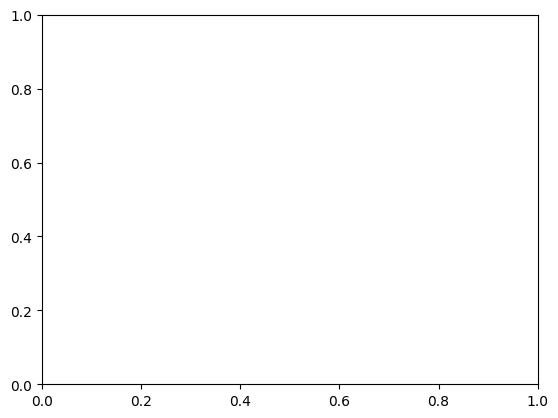

In [42]:

# Now barplot collapsing all participants into one bar per dimension
allmaes = []
stderror = []

for mmae in [maes_X, maes_Y, maes_Z]:
    allmaes.append(np.mean(mmae))
    stderror.append(np.std(mmae)/np.sqrt(len(mmae)))

fig, ax = plt.subplots()
enlargeX = 1.2
x_points = np.arange(len(allmaes)) * enlargeX
for i,posx in enumerate(x_points):
    ax.bar(posx, allmaes[i], alpha=opacity, color = colors[1], yerr=stderror[i], capsize=5, edgecolor='k')

xtickspos = []
for posx, dimension in zip(x_points,['X', 'Y', 'Z']):
    xtickspos.append((posx, dimension))
plt.xticks([xt[0] for xt in xtickspos], [xt[1] for xt in xtickspos])

plt.xlabel('Dimension')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error of trajectories between DAW and VR')


plt.savefig('plots/mae_per_dimension.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/mae_per_dimension.pdf', dpi=300, bbox_inches='tight')
plt.show()



In [6]:


# Now we split between the participants that started with 2D and 3D
toplot_byFirst = {'2D':[], '3D':[]}
toplot_err_byFirst = {'2D':[], '3D':[]}
for startedWith,curmaes in zip(['2D','3D'],[maes_startedwith2D,maes_startedwith3D]):
    # print('Started with {}'.format(startedWith))

    allmaes = []
    stderror = []

    for mmae in curmaes:
        allmaes.append(np.mean(mmae))
        toplot_byFirst[startedWith].append(np.mean(mmae))
        stderror.append(np.std(mmae)/np.sqrt(len(mmae)))
        toplot_err_byFirst[startedWith].append(np.std(mmae)/np.sqrt(len(mmae)))
    assert len(allmaes) == 3, 'There should be 3 dimensions'

    # fig, ax = plt.subplots()
    # enlargeX = 1.2
    # x_points = np.arange(len(allmaes)) * enlargeX
    # for i,posx in enumerate(x_points):

    #     ax.bar(posx, allmaes[i], alpha=opacity, color = colors[1], yerr=stderror[i], capsize=5, edgecolor='k')

    # xtickspos = []
    # for posx, dimension in zip(x_points,['X', 'Y', 'Z']):
    #     xtickspos.append((posx, dimension))
    # plt.xticks([xt[0] for xt in xtickspos], [xt[1] for xt in xtickspos])

    # plt.xlabel('Dimension')
    # plt.ylabel('Mean Absolute Error')
    # plt.title('Mean Absolute Error between 2D and 3D,\n for participants who started with {}'.format(startedWith))


    # plt.savefig('plots/mae_per_dimension_started_with_%s.png'%startedWith, dpi=300, bbox_inches='tight')
    # plt.savefig('plots/mae_per_dimension_started_with_%s.pdf'%startedWith, dpi=300, bbox_inches='tight')
    # plt.show()

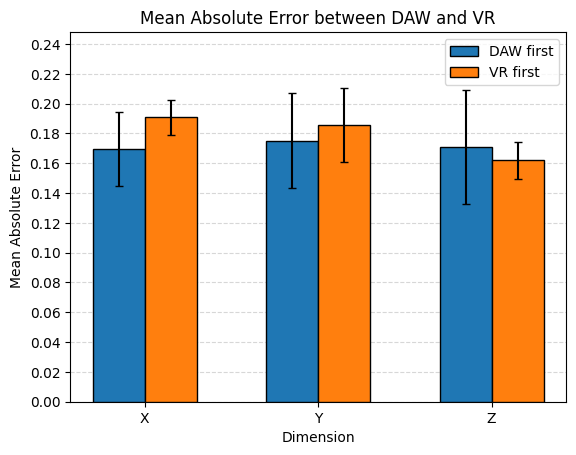

In [40]:

fig, ax = plt.subplots()


ind = np.arange(len(toplot_byFirst['2D']))    # the x locations for the groups

# Width of a bar 
width = 0.3       
plt.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)

# Plotting
plt.bar(ind, toplot_byFirst['2D'] , width, label='DAW first', yerr=toplot_err_byFirst['2D'], capsize=3, edgecolor='k', zorder=10)
plt.bar(ind + width, toplot_byFirst['3D'], width, label='VR first', yerr=toplot_err_byFirst['3D'], capsize=3, edgecolor='k', zorder=10)

# draw vertocal lines at ind
# for x in ind:
#     plt.axvline(x=x+width/2, color='black', linestyle='--', lw=1)
plt.ylim(0, 1.3*max([max(toplot_byFirst['2D']), max(toplot_byFirst['3D'])]))

# Put xticks at the middle of the bars
plt.xticks(ind + width/2, ['X', 'Y', 'Z'])

# yticks every 0.025
yticks = np.arange(0, 1.31*max([max(toplot_byFirst['2D']), max(toplot_byFirst['3D'])]), 0.02)
plt.yticks(yticks)

#grid

plt.legend(loc='upper right')
plt.xlabel('Dimension')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error between DAW and VR')

plt.savefig('plots/mae_per_dimension_bystart.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/mae_per_dimension_bystart.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# toplot_byFirst
import pandas as pd
df = pd.DataFrame(toplot_byFirst)
add = pd.DataFrame({'Dimension': ['X', 'Y', 'Z']})
df = pd.concat([add, df], axis=1)
csvprint = df.to_csv(index=False)
print(csvprint)

Dimension,2D,3D
X,0.16946249057677723,0.19073681176471277
Y,0.1752227773175042,0.18569977516811376
Z,0.17100404834371952,0.16188172363938258



len(curmaes): 3
len(curmaes): 3


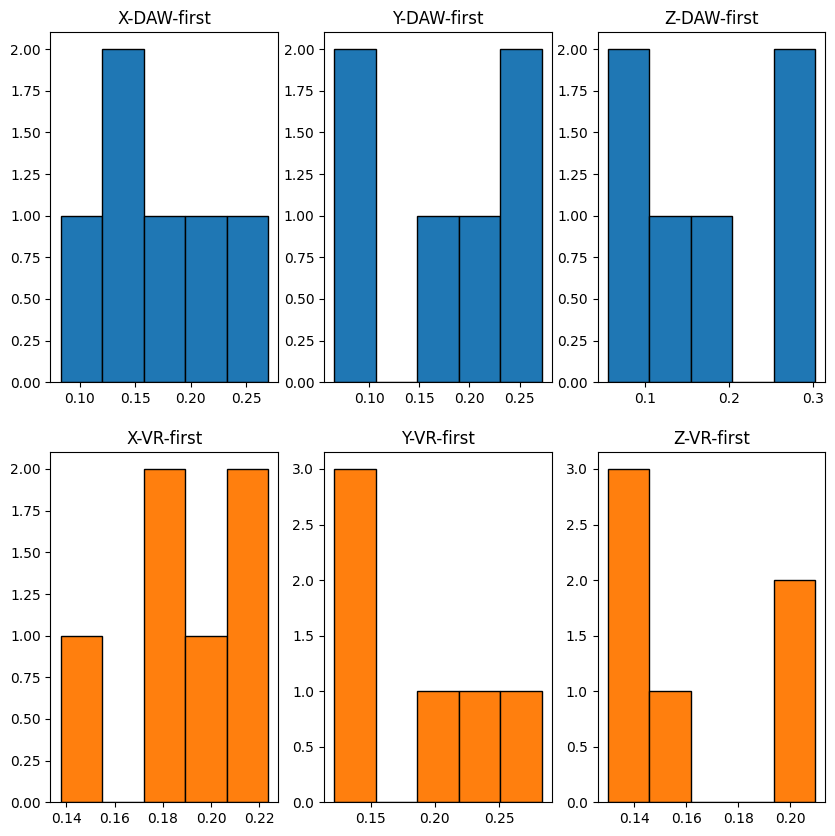

In [9]:
# Plot all 4 histograms (toplot_byFirst)

fig, ax = plt.subplots(2, 3, figsize=(10,10))

DEFAULT_MATPLOTLIB_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (startedWith,curmaes, curax) in enumerate(zip(['2D','3D'],[maes_startedwith2D,maes_startedwith3D], ax)):
    allmaes = []
    stderror = []

    print('len(curmaes):', len(curmaes))

    for j,mmae in enumerate(curmaes):
        curcurax = curax[j]
        bins = curcurax.hist(mmae, bins=5, label='Dimension %s'%['X','Y','Z'][i], edgecolor='k', color=DEFAULT_MATPLOTLIB_COLORS[0] if startedWith == '2D' else DEFAULT_MATPLOTLIB_COLORS[1])
        
        # Only whole yticks
        # yticks = range(0, max(bins[0])+1, 2)
        # curcurax.set_yticks(yticks)

        typename = 'DAW' if startedWith == '2D' else 'VR'
        curcurax.set_title(['X','Y','Z'][j]+'-'+typename+'-first')



